In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.datasets import CachedDatasets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import seaborn as sbn

import networkx as nx

from sklearn.feature_selection import RFE

import os

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

from kneed import KneeLocator

In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
C:\anaconda-3.5.2.0\lib\site-packages\tslearn\clustering\kmeans.py:17: UserWarning: Sci

In [3]:
os.listdir('../data/HER2/')

['H210122_SKBR3',
 'H210205_Set1',
 'H210205_Set2',
 'H210212_Set1',
 'H210212_Set2',
 'H210219_Set1',
 'H210219_Set2']

In [4]:
load = 'normalized' # or 'raw'

series_sel = pd.read_csv('../data/HER2/H210122_SKBR3/normalized/clover_all_cell.csv').columns[1:-3]

_datas = []
for dataset in os.listdir('../data/HER2'): 
    cl_path = '../data/HER2/' + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = '../data/HER2/' + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)
    
data = pd.concat(_datas, axis=0)

clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()

,track_index,0.0_x,0.2_x,0.5_x,0.8_x,1.0_x,1.2_x,1.5_x,1.8_x,2.0_x,...,57.5_y,57.8_y,58.0_y,58.2_y,site_y,median_y,dataset,drug,cell_line,mutant
0,69_1000049620_skbr3_erk_akt__WT_untreated,0.784316,0.786841,0.603200,0.541081,0.458533,0.431992,0.712106,0.699950,0.730170,...,0.242807,0.127572,0.132009,0.047259,69,0.299107,H210122_SKBR3,untreated,skbr3,WT
1,2_1000028311_skbr3_erk_akt__WT_untreated,0.602541,0.605066,0.421425,0.605618,0.691947,0.672889,0.614016,0.661317,0.682537,...,0.557662,0.562536,0.564215,0.564624,2,0.693558,H210122_SKBR3,untreated,skbr3,WT
2,69_1000046124_skbr3_erk_akt__WT_untreated,0.777447,0.753066,0.476562,0.595350,0.605771,0.767272,0.737938,0.733756,0.776656,...,0.522485,0.451602,0.484998,0.550944,69,0.509604,H210122_SKBR3,untreated,skbr3,WT
3,0_1000000658_skbr3_erk_akt__WT_untreated,0.831403,0.652266,0.454141,0.696562,0.757371,0.882979,0.805273,0.936487,0.915338,...,0.779451,0.878771,0.866162,0.826636,0,0.607951,H210122_SKBR3,untreated,skbr3,WT
4,75_1000100136_skbr3_erk_akt__WT_untreated,0.165367,0.141473,0.447377,0.482309,0.478944,0.658566,0.682605,0.727898,0.744381,...,0.562468,0.551105,0.634450,0.626864,75,0.668938,H210122_SKBR3,untreated,skbr3,WT


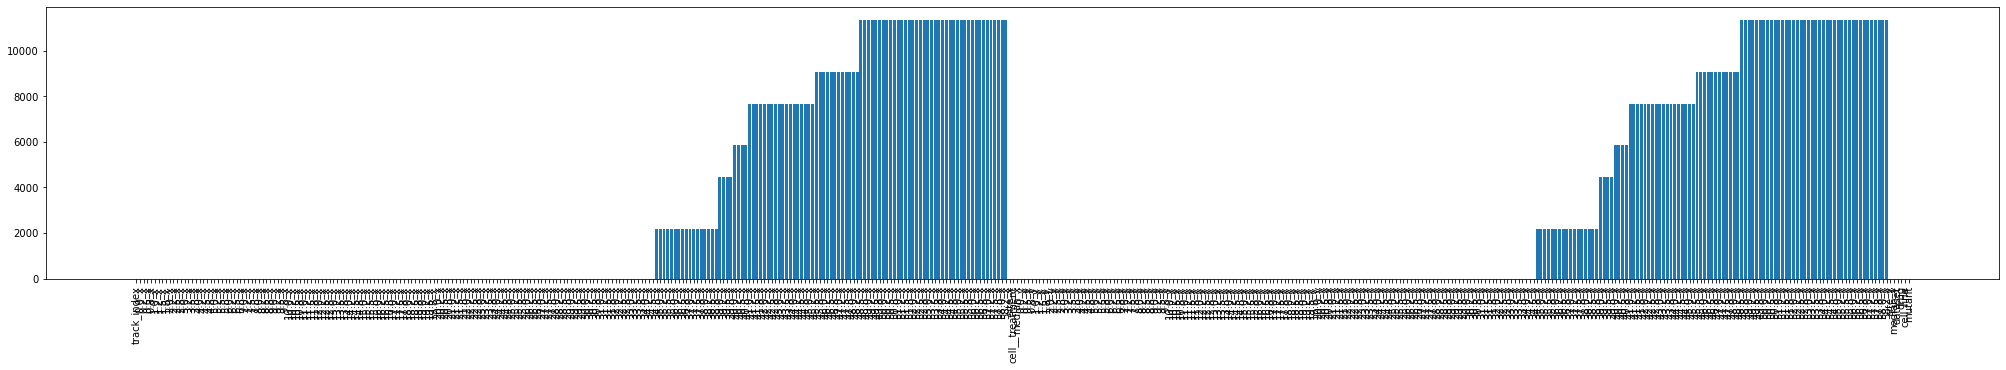

In [5]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

In [6]:
data = data[lambda x: x.drug.isin(['untreated', '10nm_neratinib'])]
data.shape

(9522, 478)

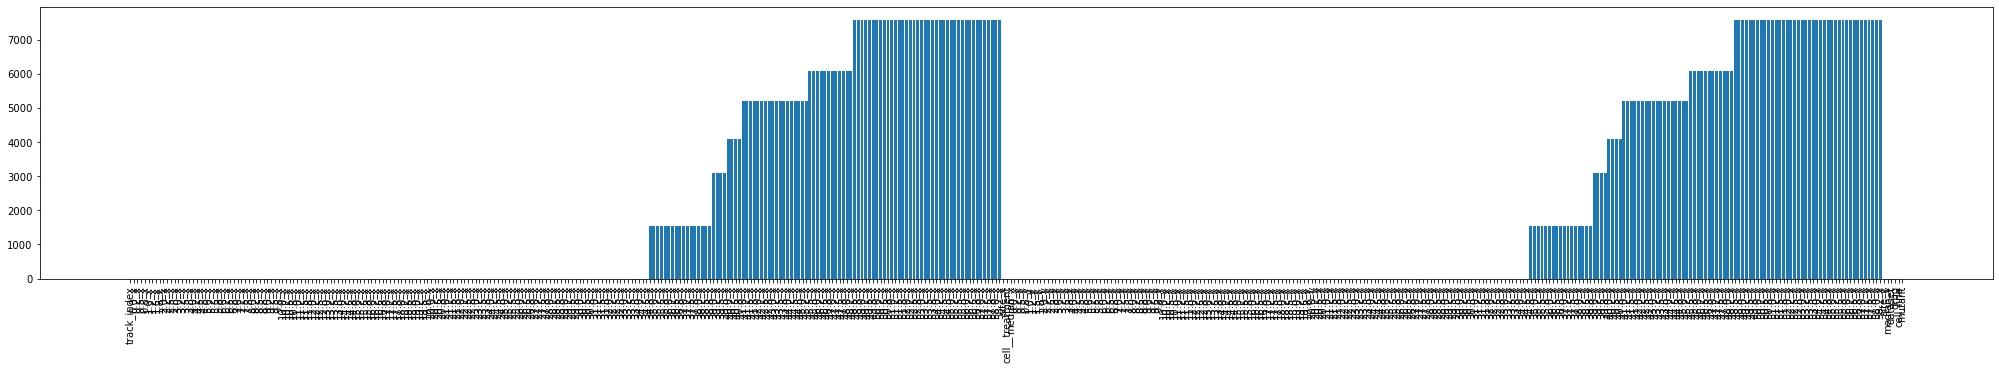

In [7]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

In [7]:
# remove na
clover_sel = np.array(clover_sel)[~data[clover_sel].isna().any()]
mscarl_sel = np.array(mscarl_sel)[~data[mscarl_sel].isna().any()]

In [9]:
#X_train = data[clover_sel]
X_train = np.stack([data[clover_sel], data[mscarl_sel]], axis=2)
print(X_train.shape)

# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
sz = X_train.shape[1]
print(X_train.shape)

(9522, 139, 2)
(9522, 100, 2)


# Choose # of Clusters

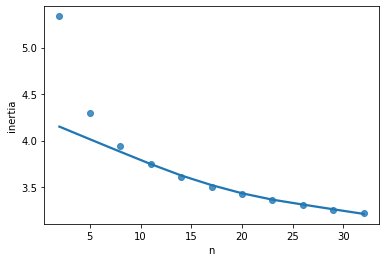

In [13]:
clus_res = {'n':[] , 'inertia':[]}
for n in np.arange(2,35,3):
    print(f'Training kmeans with {n} clusters', end='\r')
    model = TimeSeriesKMeans(n_clusters=n, verbose=False, random_state=0, metric='euclidean', n_jobs=8)
    model.fit(X_train)
    clus_res['n'].append(n)
    clus_res['inertia'].append(model.inertia_)
clus_res = pd.DataFrame(clus_res)

elbow point: 3.9430629518812133


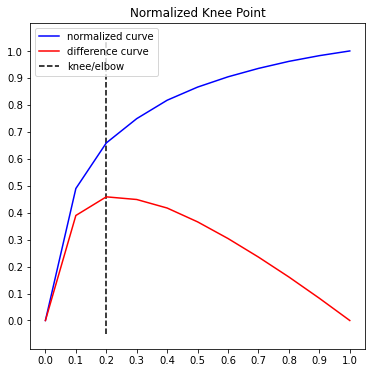

In [26]:
kneedle = KneeLocator(clus_res.n, clus_res.inertia, S=1.0, curve="convex", direction="decreasing")
kneedle.plot_knee_normalized()
print('elbow point:', kneedle.knee_y)

# Cluster

In [54]:
nclus = 25

In [55]:
km = TimeSeriesKMeans(n_clusters=nclus, verbose=True, random_state=0, metric='euclidean', n_jobs=8)
y_pred = km.fit_predict(X_train)

4.607 --> 3.562 --> 3.467 --> 3.426 --> 3.399 --> 3.383 --> 3.372 --> 3.363 --> 3.357 --> 3.352 --> 3.348 --> 3.345 --> 3.343 --> 3.341 --> 3.340 --> 3.339 --> 3.338 --> 3.337 --> 3.336 --> 3.335 --> 3.334 --> 3.334 --> 3.333 --> 3.332 --> 3.331 --> 3.331 --> 3.330 --> 3.329 --> 3.329 --> 3.328 --> 3.327 --> 3.327 --> 3.326 --> 3.325 --> 3.325 --> 3.324 --> 3.324 --> 3.323 --> 3.323 --> 3.322 --> 3.322 --> 3.322 --> 3.321 --> 3.321 --> 3.321 --> 3.321 --> 3.321 --> 3.321 --> 3.320 --> 3.320 --> 


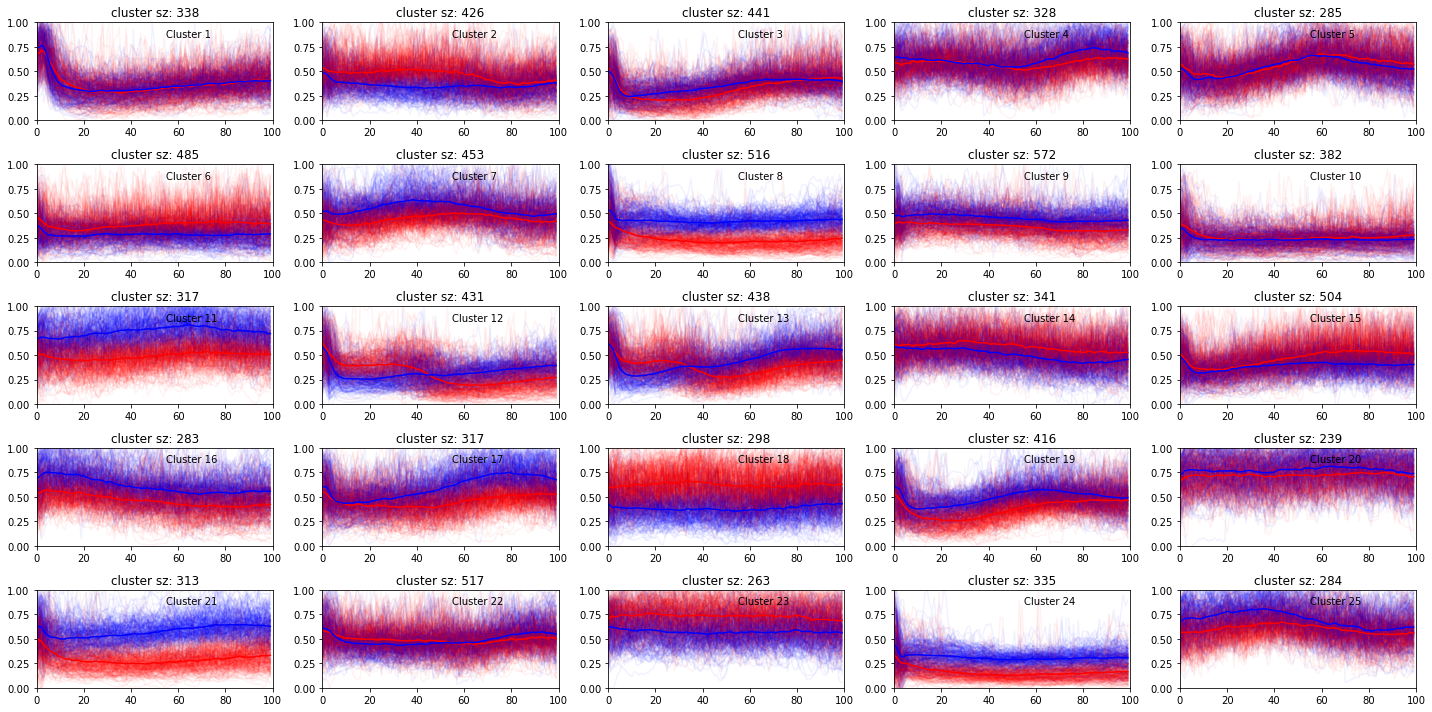

In [56]:
plt.figure(figsize=(20,10))
for yi in range(nclus):
    plt.subplot(5, 5, yi + 1)
    for xx in X_train[y_pred == yi][0:250]:
        plt.plot(xx[:,0], "r-", alpha=.05)
        plt.plot(xx[:,1], "b-", alpha=.05)
        
    plt.title(f'cluster sz: {len(X_train[y_pred == yi])}')
    plt.plot(km.cluster_centers_[yi][:,0], "r-", label='clover')
    plt.plot(km.cluster_centers_[yi][:,1], "b-", label='mscarlet')
    
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [59]:
lb = LabelEncoder()
y_trt = lb.fit_transform([f'{x}--{y}' for x,y in zip(data.cell__treatment.values, data.dataset.values)])

cm_cnts = {c:np.zeros(nclus) for c in lb.classes_} 

for i, clus, grp in zip(range(len(y_pred)), y_pred, y_trt) :
    cm_cnts[lb.classes_[grp]][clus] += 1
    
cm_prob = {k:v/np.sum(v) for k,v in cm_cnts.items()}

labels = [k for k,v in cm_prob.items()]
cm = np.stack([v for k,v in cm_prob.items()], axis=0)

In [61]:
cm.shape

(124, 25)

# Endogenous clusters

Are there any clusters that ALL cells have small proportions of? 

array([[0.        , 0.09803922, 0.07843137, ..., 0.        , 0.03921569,
        0.        ],
       [0.        , 0.10638298, 0.        , ..., 0.04255319, 0.06382979,
        0.        ],
       [0.08965517, 0.04137931, 0.08275862, ..., 0.        , 0.0137931 ,
        0.00689655],
       ...,
       [0.01315789, 0.03947368, 0.        , ..., 0.06578947, 0.        ,
        0.05263158],
       [0.03174603, 0.11111111, 0.14285714, ..., 0.        , 0.03174603,
        0.        ],
       [0.01886792, 0.05660377, 0.01886792, ..., 0.01886792, 0.        ,
        0.01886792]])

# Cluster co-occurence

<Figure size 504x504 with 0 Axes>

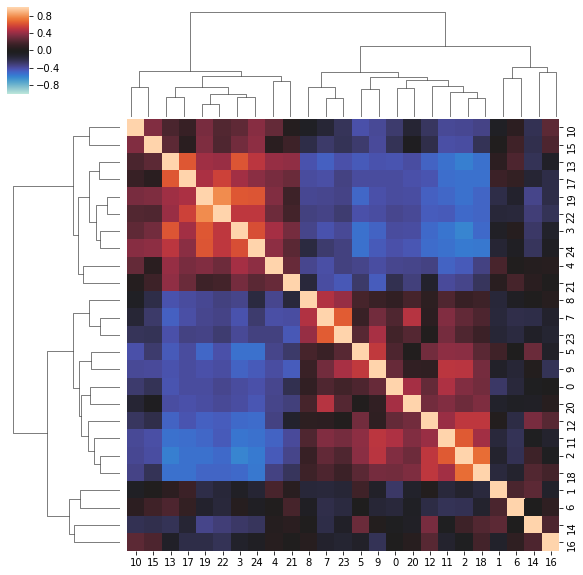

In [62]:
corr = np.corrcoef(cm, rowvar=False)

plt.figure(figsize=(7,7))
ax = sbn.clustermap(
    corr, 
    vmin=-1, vmax=1, center=0,
    square=True
)
plt.show()

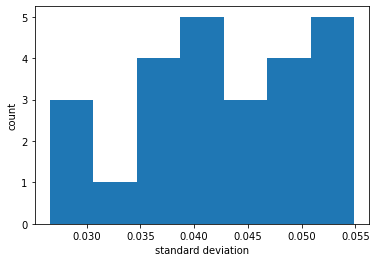

In [63]:
cm_stds = cm.std(axis=0)

plt.figure()
plt.hist(cm_stds, bins=7)
plt.ylabel('count')
plt.xlabel('standard deviation')
plt.show()

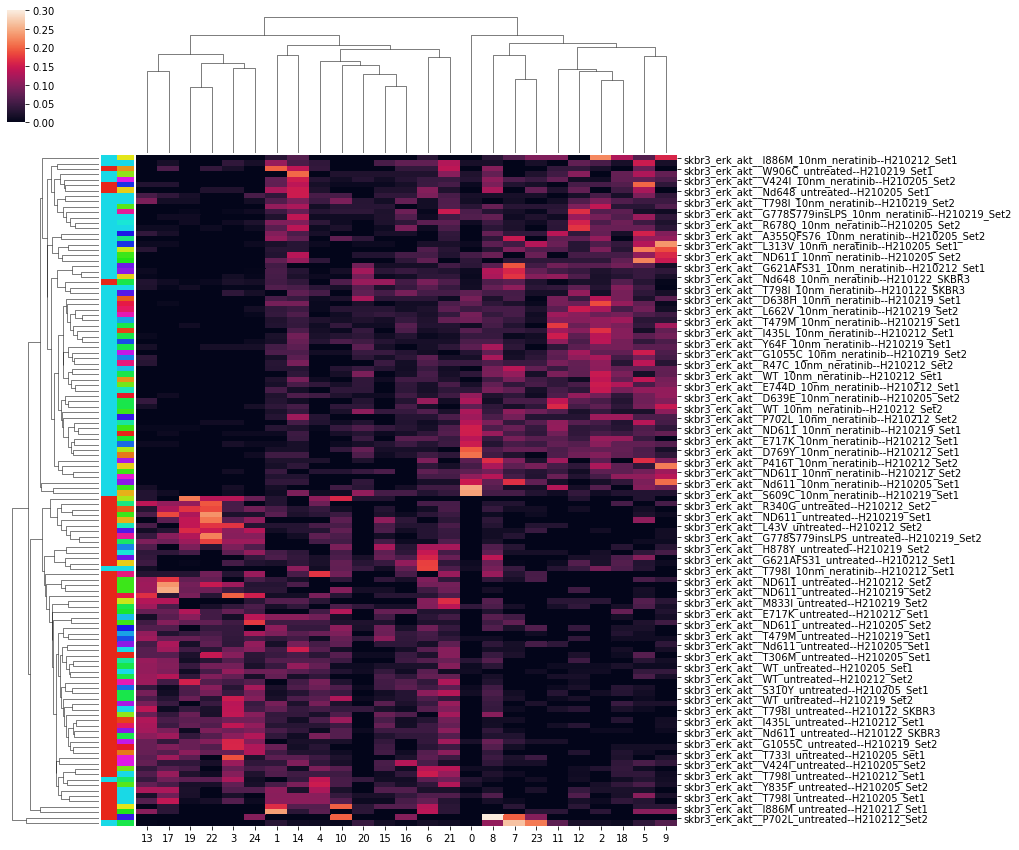

In [64]:
#drug = dict(zip(data.drug.unique(), "rbg"))
#row_colors = data.drug.map(drug)
#g = sbn.clustermap(cm, row_colors=row_colors)
# [x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]

drug = [x.split('--')[0].split('_')[-1] for x in labels]
lut = dict(zip(set(drug), sbn.hls_palette(len(set(drug)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(drug)[0].map(lut)

#Create additional row_colors here
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels, data=cm)
sbn.clustermap(df, figsize=(12,15), row_colors=[row_colors, row_colors2]) 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Clustermap within JUST neratinib

In [172]:
labels2_sel = ['neratinib' in x for x in labels]
labels2 = np.array(labels)[labels2_sel]
cm2 = cm[labels2_sel, :]

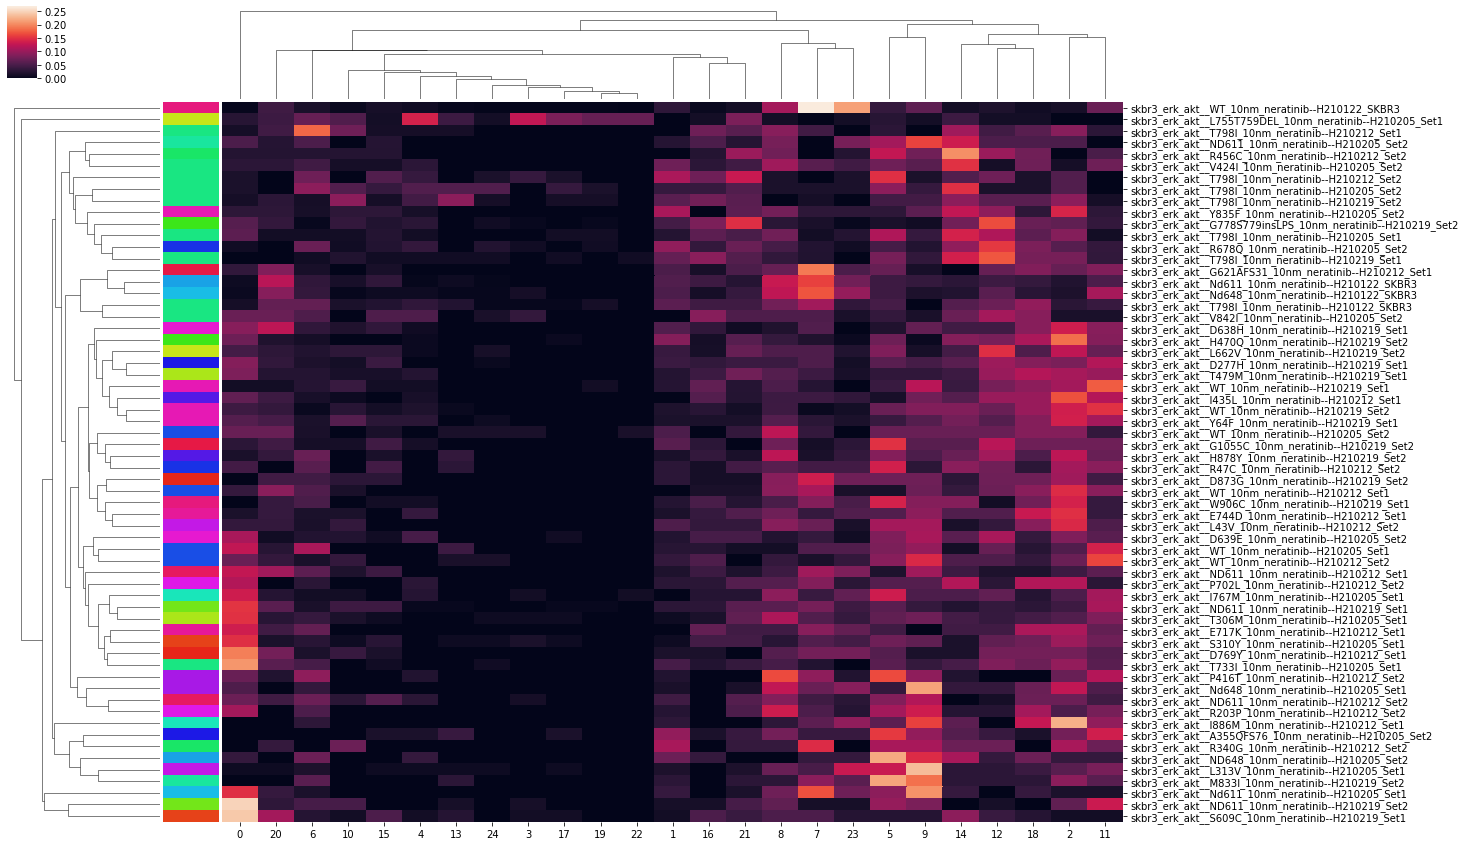

In [177]:
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels2, data=cm2)
sbn.clustermap(df, figsize=(20,15), row_colors=[row_colors2], metric='euclidean') 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Dimensionality Reduction

In [65]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(cm)

print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})
res.head()

explained variance ratio: [0.38455472 0.09196815]
PC shape: (124, 2)


,pc1,pc2,treatment,cell_line
0,-0.118267,-0.033145,neratinib,A355QFS76
1,0.065132,-0.037082,untreated,A355QFS76
2,-0.137833,0.002963,neratinib,D277H
3,0.178354,0.004942,untreated,D277H
4,-0.141118,0.026790,neratinib,D638H


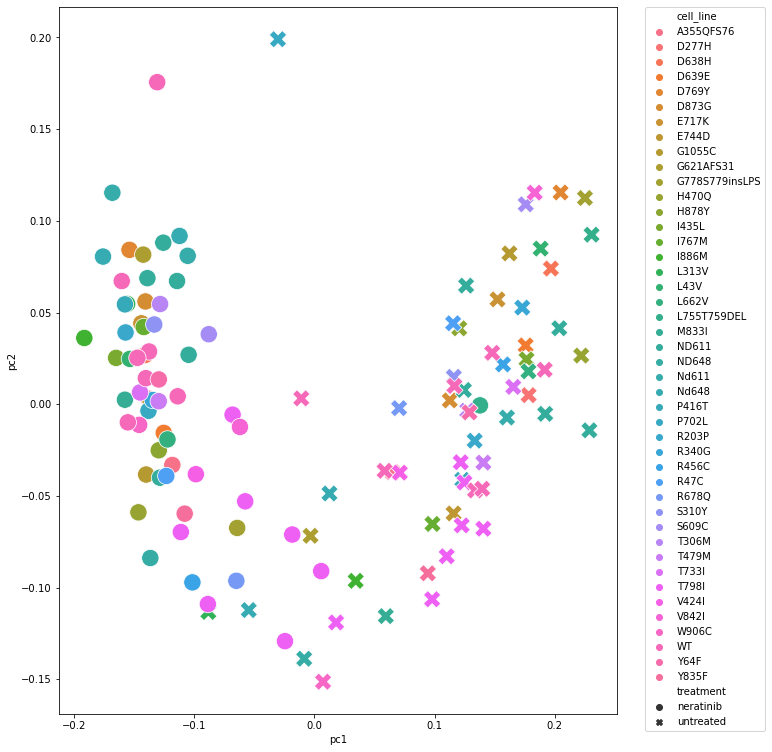

In [66]:
plt.figure(figsize=(10,13))
sbn.scatterplot(x='pc1', y='pc2', data=res, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

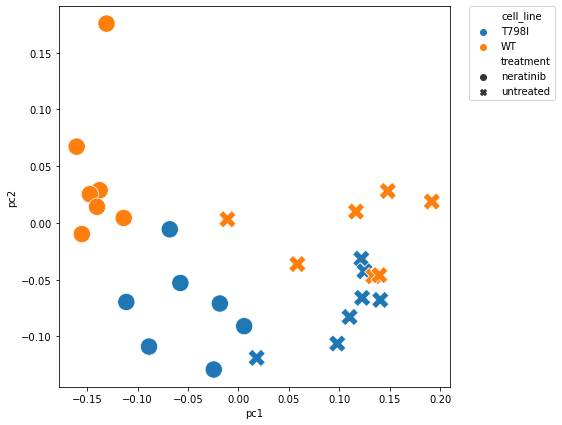

In [67]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [68]:
res.head()

,pc1,pc2,treatment,cell_line
0,-0.118267,-0.033145,neratinib,A355QFS76
1,0.065132,-0.037082,untreated,A355QFS76
2,-0.137833,0.002963,neratinib,D277H
3,0.178354,0.004942,untreated,D277H
4,-0.141118,0.026790,neratinib,D638H


In [95]:
res_ner = res[lambda x: (x.cell_line.isin(['WT', 'T798I'])) & (x.treatment == 'neratinib')]

X = 5* res_ner[['pc1', 'pc2']].values
y = 1.*((res_ner.cell_line == 'WT') & (res_ner.treatment == 'neratinib')).values #+  2.* (res_ner.treatment == 'untreated').values

In [96]:
np.unique(y)

array([0., 1.])

In [97]:
X.shape

(14, 2)

Accuracy (train) for L1 logistic: 100.0% 
Accuracy (train) for L2 logistic (Multinomial): 100.0% 
Accuracy (train) for L2 logistic (OvR): 100.0% 
Accuracy (train) for Linear SVC: 100.0% 
Accuracy (train) for GPC: 100.0% 


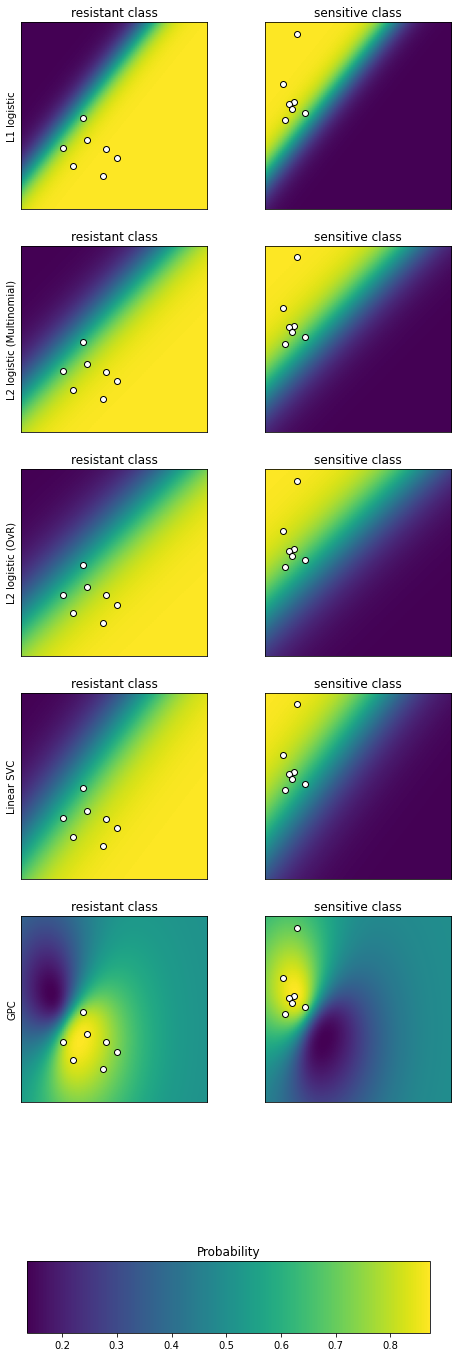

In [111]:
n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel)
}

n_classifiers = len(classifiers)

plt.figure(figsize=(4 * 2, n_classifiers * 4))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

class_names = ['resistant', 'sensitive', 'untreated']
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("%s class" % class_names[k])
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(-1, 1, -1, 1), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [158]:
ner_other = res[lambda x: ~(x.cell_line.isin(['WT', 'T798I'])) & (x.treatment == 'neratinib')].reset_index(drop=True)
ner_other.shape

(48, 4)

In [159]:
ner_other = res[lambda x: ~(x.cell_line.isin(['WT', 'T798I'])) & (x.treatment == 'neratinib')].reset_index(drop=True)

X_all = 5*ner_other[['pc1', 'pc2']].values

y_hat = classifiers['Linear SVC'].predict_proba(X_all)

pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1]})#, 'prob_untreat':y_hat[:,2]})
res2 = pd.concat([ner_other, pres], axis=1) # ,'untreat'
res2 = res2.assign(call=[['res','sens'][np.argmax([x,y])] for x,y in zip(res2.prob_res, res2.prob_sens)])#, res2.prob_untreat)])


(48, 2)

In [160]:
y_hat = classifiers['Linear SVC'].predict_proba(X_all)
y_hat.shape

(48, 2)

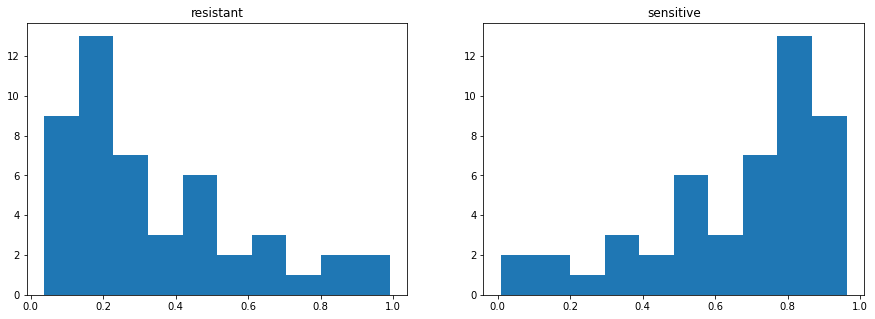

In [161]:
f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(y_hat[:,0])
ax[0].set_title('resistant')
ax[1].hist(y_hat[:,1])
ax[1].set_title('sensitive')
#ax[2].hist(y_hat[:,2])
#ax[2].set_title('untreated')
plt.show()

In [163]:
del pres
pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1]})#, 'prob_untreat':y_hat[:,2]})
res2 = pd.concat([ner_other, pres], axis=1) # ,'untreat'
res2 = res2.assign(call=[['res','sens'][np.argmax([x,y])] for x,y in zip(res2.prob_res, res2.prob_sens)])#, res2.prob_untreat)])
res2.head()

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
0,-0.118267,-0.033145,neratinib,A355QFS76,0.525128,0.474872,res
1,-0.137833,0.002963,neratinib,D277H,0.296291,0.703709,sens
2,-0.141118,0.026790,neratinib,D638H,0.213127,0.786873,sens
3,-0.125406,-0.015629,neratinib,D639E,0.420354,0.579646,sens
4,-0.153925,0.084191,neratinib,D769Y,0.077993,0.922007,sens


In [164]:
res2.groupby(['call', 'treatment'])[['cell_line']].count()

,,cell_line
call,treatment,
res,neratinib,11
sens,neratinib,37


In [166]:
res2[lambda x: x.call == 'res'].sort_values('prob_res', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
19,0.137856,-0.000632,neratinib,L755T759DEL,0.991857,0.008143,res
37,-0.064964,-0.096309,neratinib,R678Q,0.898312,0.101688,res
10,-0.064259,-0.067477,neratinib,G778S779insLPS,0.850730,0.149270,res
35,-0.101553,-0.097168,neratinib,R456C,0.809437,0.190563,res
44,-0.061972,-0.012389,neratinib,V842I,0.715475,0.284525,res
47,-0.107976,-0.059679,neratinib,Y835F,0.670540,0.329460,res
43,-0.098661,-0.038181,neratinib,V424I,0.639015,0.360985,res
26,-0.136581,-0.083885,neratinib,ND648,0.626682,0.373318,res
0,-0.118267,-0.033145,neratinib,A355QFS76,0.525128,0.474872,res
36,-0.123298,-0.039117,neratinib,R47C,0.522941,0.477059,res


In [167]:
res2.sort_values('prob_sens', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
28,-0.168198,0.115335,neratinib,Nd611,0.037368,0.962632,sens
30,-0.175964,0.080517,neratinib,Nd648,0.054114,0.945886,sens
15,-0.191536,0.036112,neratinib,I886M,0.077150,0.922850,sens
4,-0.153925,0.084191,neratinib,D769Y,0.077993,0.922007,sens
9,-0.142498,0.081580,neratinib,G621AFS31,0.100106,0.899894,sens
31,-0.157725,0.054449,neratinib,P416T,0.111023,0.888977,sens
16,-0.155873,0.054694,neratinib,L313V,0.114416,0.885584,sens
22,-0.125788,0.088099,neratinib,ND611,0.123739,0.876261,sens
25,-0.139011,0.068740,neratinib,ND611,0.127526,0.872474,sens
33,-0.157207,0.039126,neratinib,R203P,0.138388,0.861612,sens


In [53]:
res2[lambda x: x.prob_untreat > 0.75]

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,prob_untreat,call
3,0.419514,0.026924,untreated,D277H,0.107484,0.009487,0.883029,untreat
5,0.405439,0.079045,untreated,D638H,0.145880,0.013264,0.840856,untreat
7,0.404242,0.030600,untreated,D639E,0.120612,0.010610,0.868778,untreat
9,0.532783,0.377056,untreated,D769Y,0.210888,0.017309,0.771802,untreat
11,0.333792,-0.039563,untreated,D873G,0.142784,0.014565,0.842651,untreat
15,0.305785,-0.066869,untreated,E744D,0.152741,0.016051,0.831208,untreat
21,0.492899,0.210142,untreated,G778S779insLPS,0.141353,0.010679,0.847968,untreat
23,0.469785,0.104237,untreated,H470Q,0.106464,0.008681,0.884855,untreat
27,0.438445,0.131512,untreated,I435L,0.146049,0.012668,0.841282,untreat
29,0.238962,-0.081892,untreated,I767M,0.215413,0.023252,0.761335,untreat


# Shapelets 

In [9]:
data2 = data[lambda x: x.drug.isin(['10nm_neratinib']) & (x.mutant.isin(['WT', 'T798I']))].reset_index(drop=True)

#X_train = data[clover_sel]
X_train = np.stack([data2[clover_sel], data2[mscarl_sel]], axis=2)
print(X_train.shape)

y_train = 1*np.array([x == 'WT' for x in data2.mutant.values])
np.unique(y_train)

(1484, 139, 2)


array([0, 1])

In [10]:
# Author: Gilles Vandewiele
# License: BSD 3 clause

# Set a seed to ensure determinism
np.random.seed(42)

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 2}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(lr=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)

shp_clf.fit(X_train, y_train)

# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
fig_ax3c = fig.add_subplot(gs[2, :2])
fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(numpy.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * numpy.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = numpy.min(distances[:, 0]) - 0.1
xmax = numpy.max(distances[:, 0]) + 0.1
ymin = numpy.min(distances[:, 1]) - 0.1
ymax = numpy.max(distances[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

Instructions for updating:
Colocations handled automatically by placer.


C:\anaconda-3.5.2.0\lib\site-packages\tslearn\shapelets\shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'